In [25]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
mpl.rc('font', family='Malgun Gothic')

df_member = pd.read_csv('Member_Data.csv', encoding='EUC-KR')
df_product = pd.read_csv('Product_Data.csv')
df_sales = pd.read_csv('Sales_Data05.csv')

In [26]:
# 날짜 변환
df_sales['주문일시'] = pd.to_datetime(df_sales['주문일시'], errors='coerce')
latest_date = df_sales['주문일시'].max()  # 데이터 내 최신 주문일

# RFM분석
rfm = pd.pivot_table(df_sales, index="회원번호",values=["주문일시", "구매금액"],
    aggfunc={"주문일시": [lambda x: (latest_date - x.max()).days, "count"], "구매금액": "sum"}).reset_index()

# 컬럼 이름 변경
rfm.columns = ["회원번호", "Recency", "Frequency", "Monetary"]

# RFM 점수 (5단계 )
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

# 최종 RFM 점수 계산
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)

In [27]:
# RFM 분석에 사용할 데이터만 뽑기
RFM = rfm[['회원번호', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']]
coustomer_and_product_num = df_sales[['회원번호', '제품번호']]
product_type = df_product[['제품번호', '물품대분류', '물품중분류']]

# 병합
df_merged = RFM.merge(coustomer_and_product_num, on='회원번호', how='inner')
df_merged_RFM = df_merged.merge(product_type, on='제품번호', how='inner')
df_merged_RFM.head(5)

,회원번호,R_Score,F_Score,M_Score,RFM_Score,제품번호,물품대분류,물품중분류
0,18764160,2,3,4,9,10002574V2_441,음료,빙과
1,18764160,2,3,4,9,100022290V2_1708,음료,빙과
2,18764160,2,3,4,9,100022169V2_1631,빵,앙금크림빵
3,18764160,2,3,4,9,100021606V2_1200,음료,빙과
4,18764160,2,3,4,9,10002805V2_612,생활용품,치약/칫솔


# 2. 고객 RFM 점수에 따른 물품대분류 별 인기상품 트렌드 분석

- RFM_Score(총합) 기준

In [29]:
# EDA
rfm['RFM_Score'].value_counts()

RFM_Score
8     2528
7     2513
9     2445
10    2347
11    2203
12     301
6      193
5        7
13       3
Name: count, dtype: int64

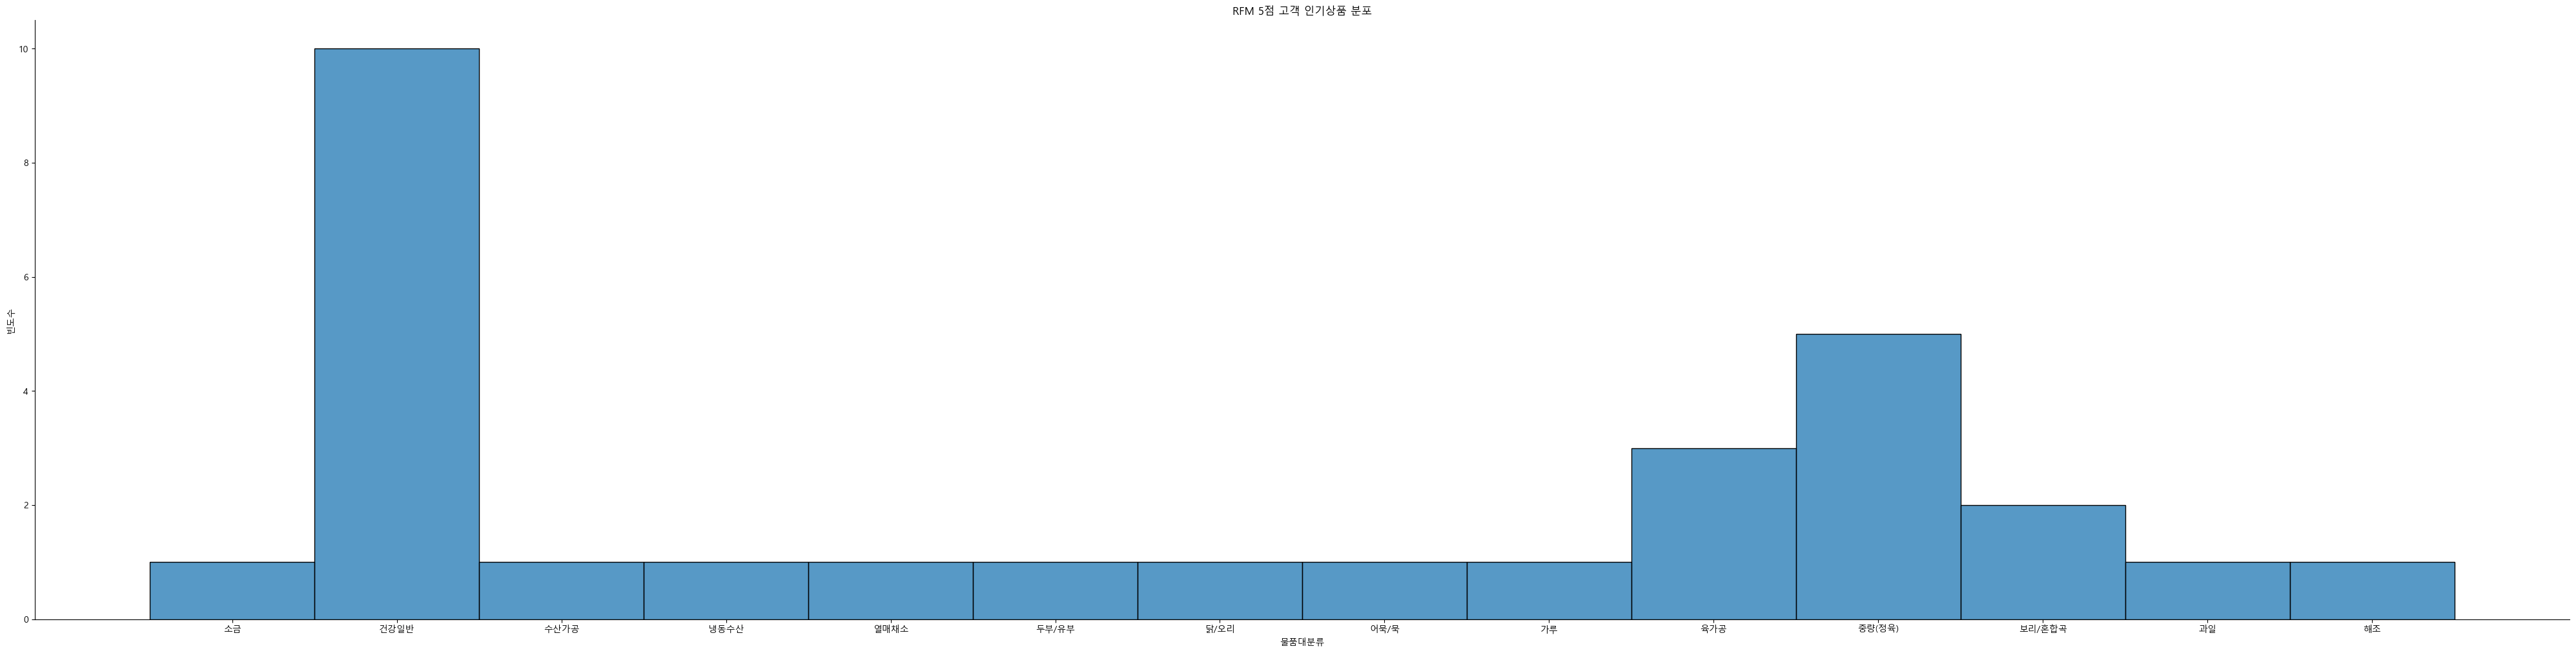

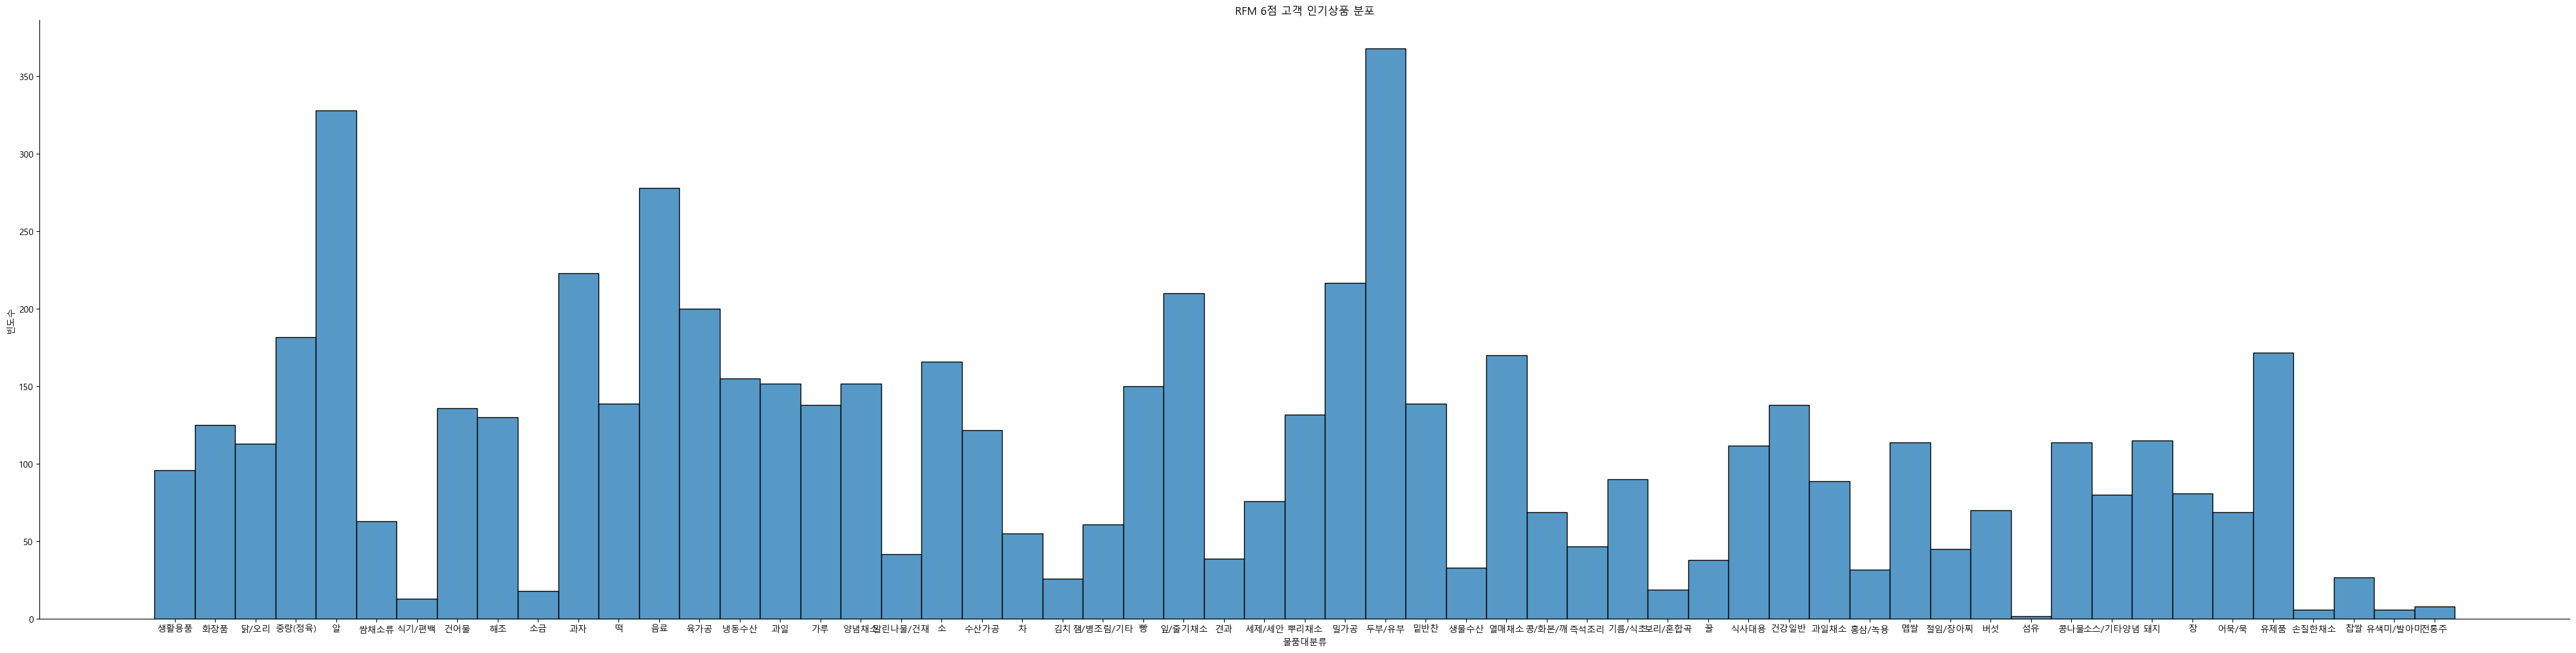

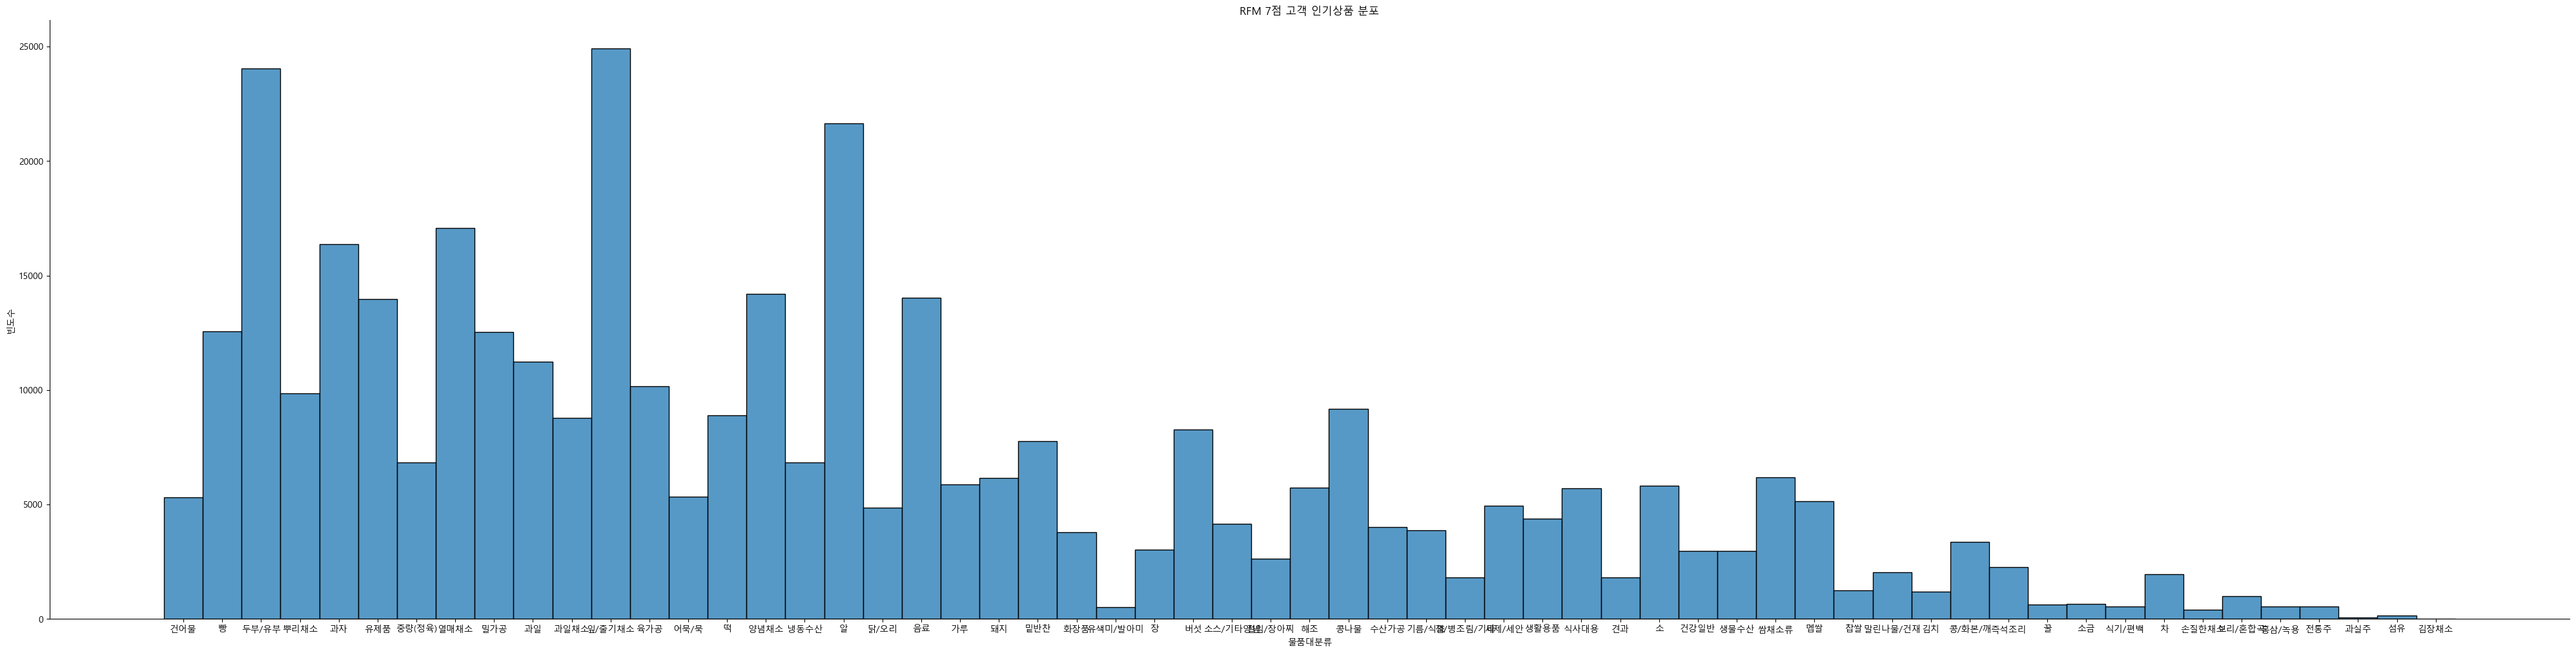

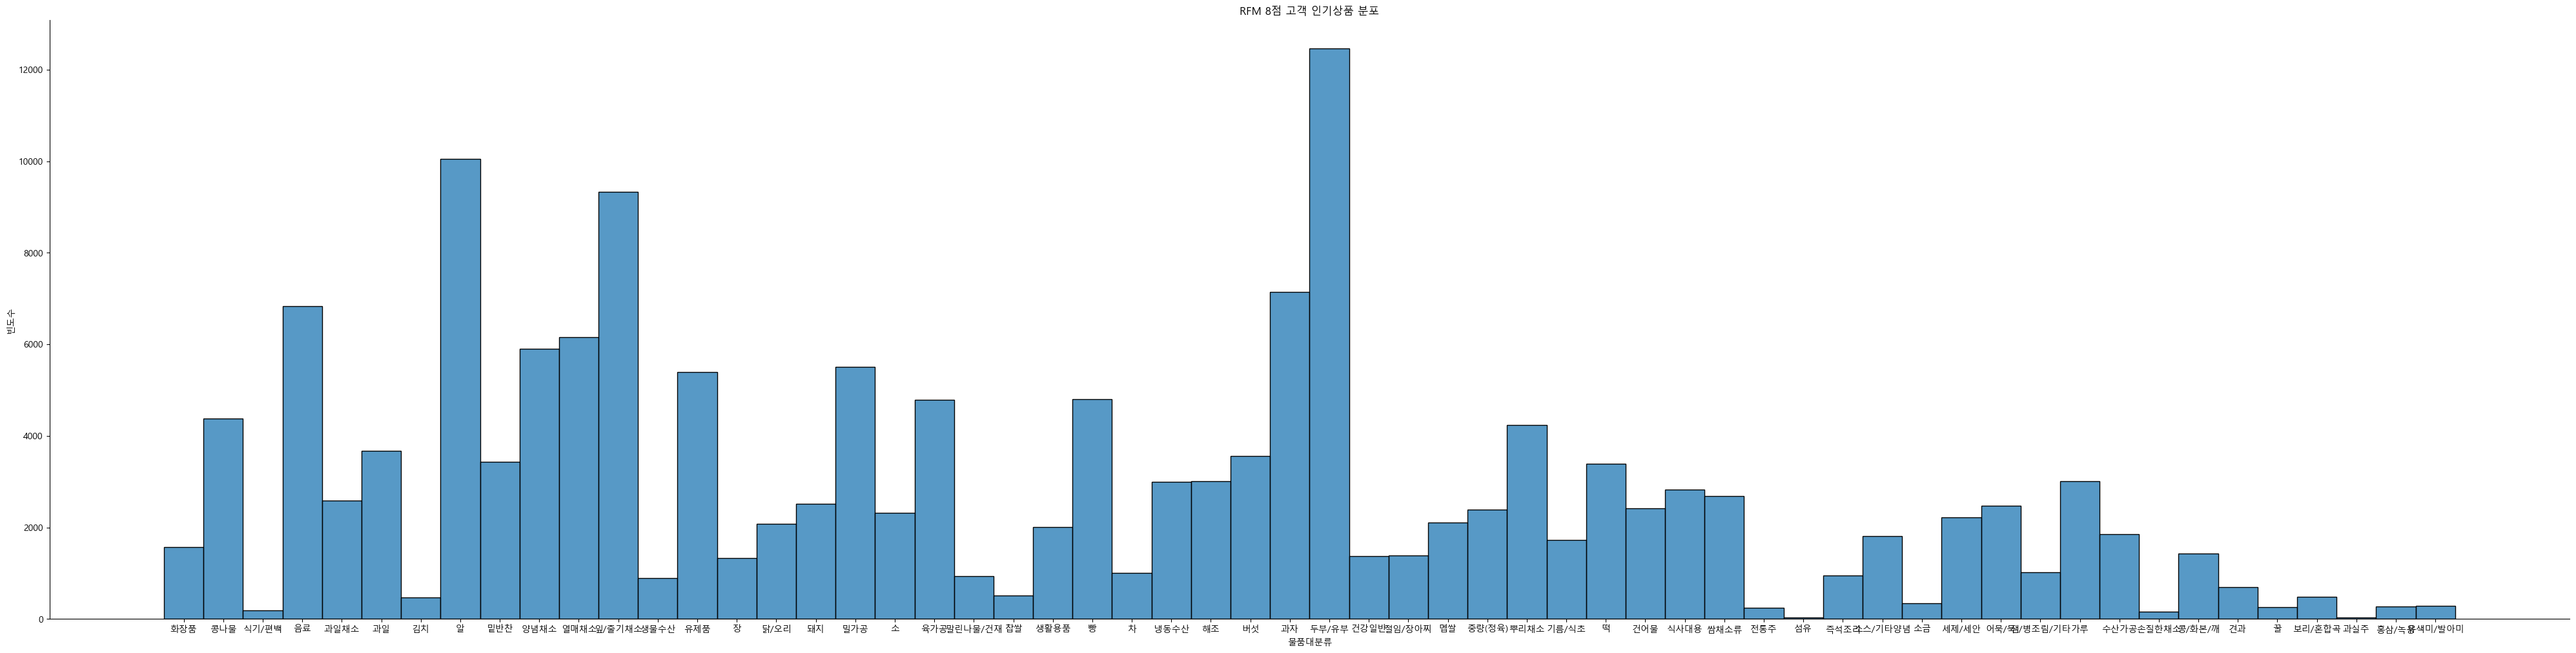

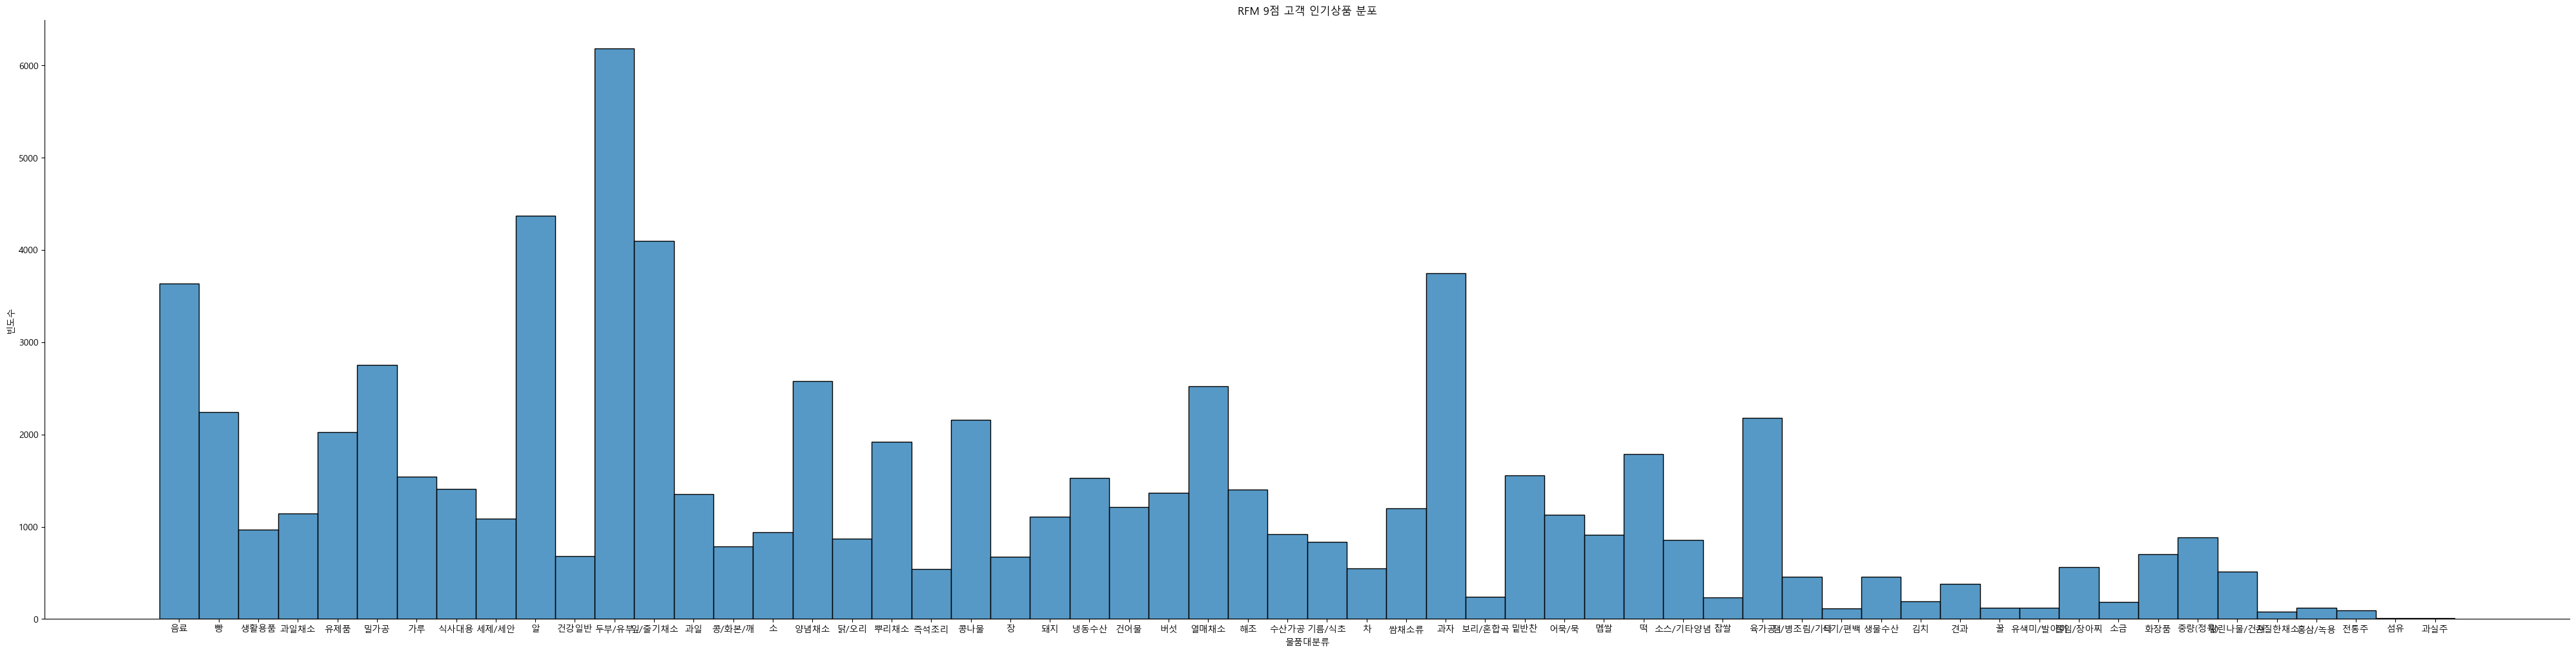

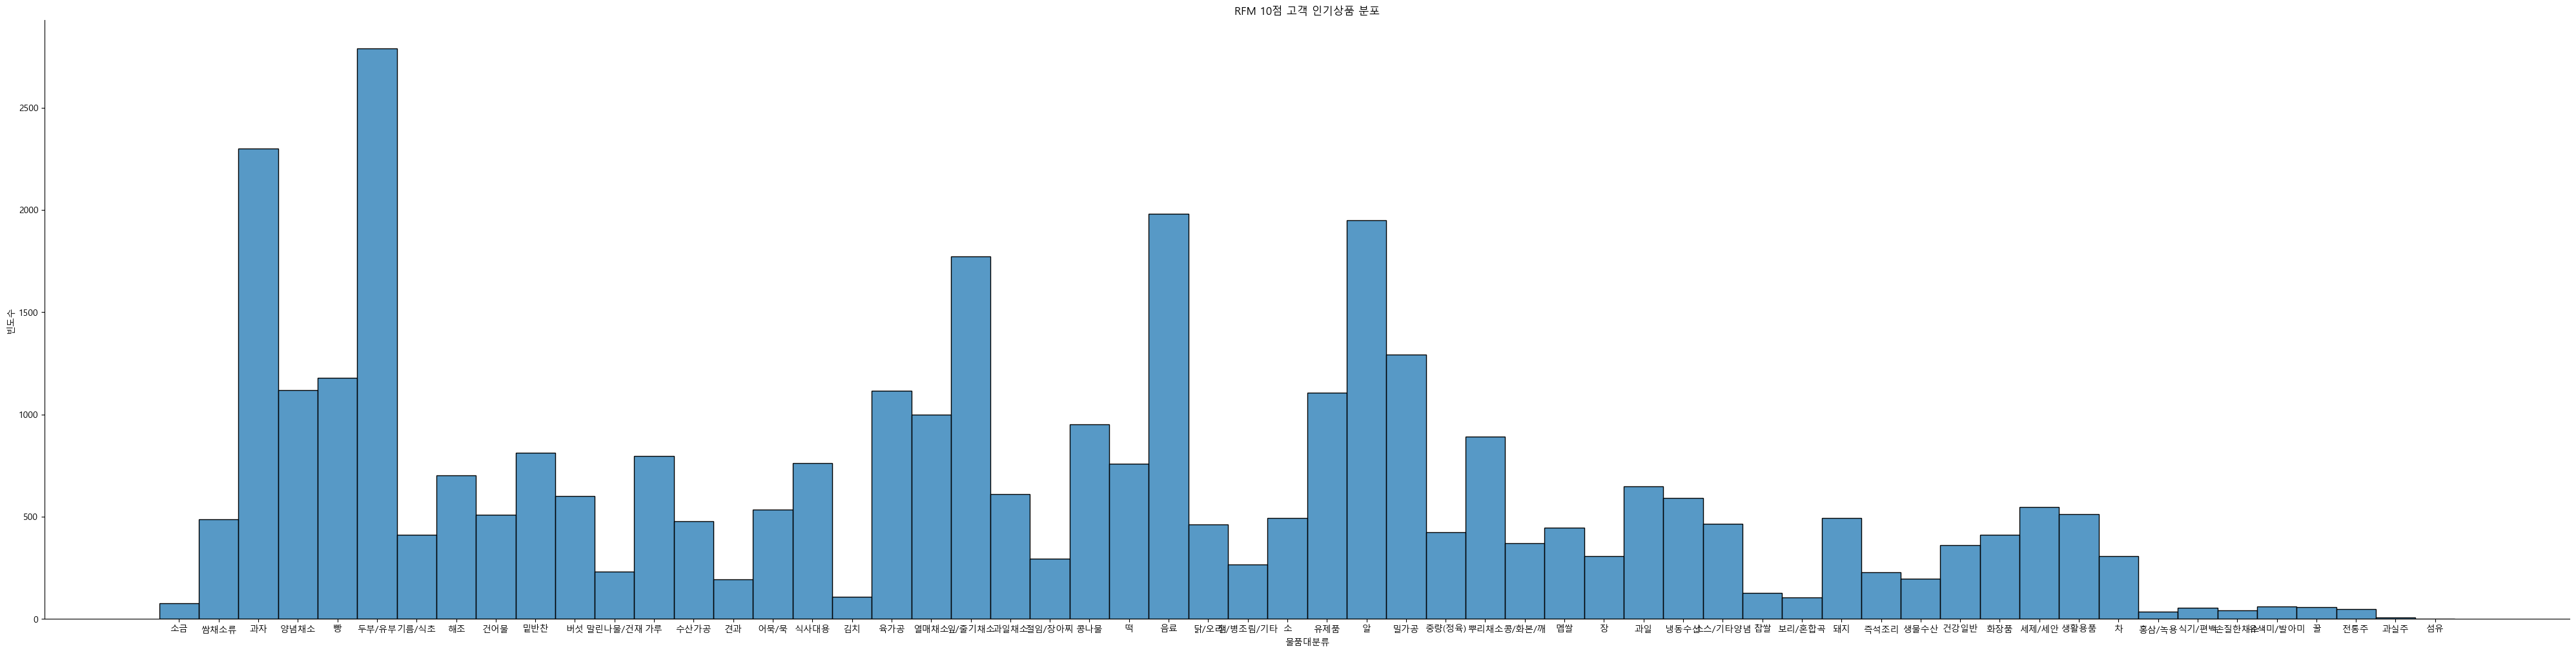

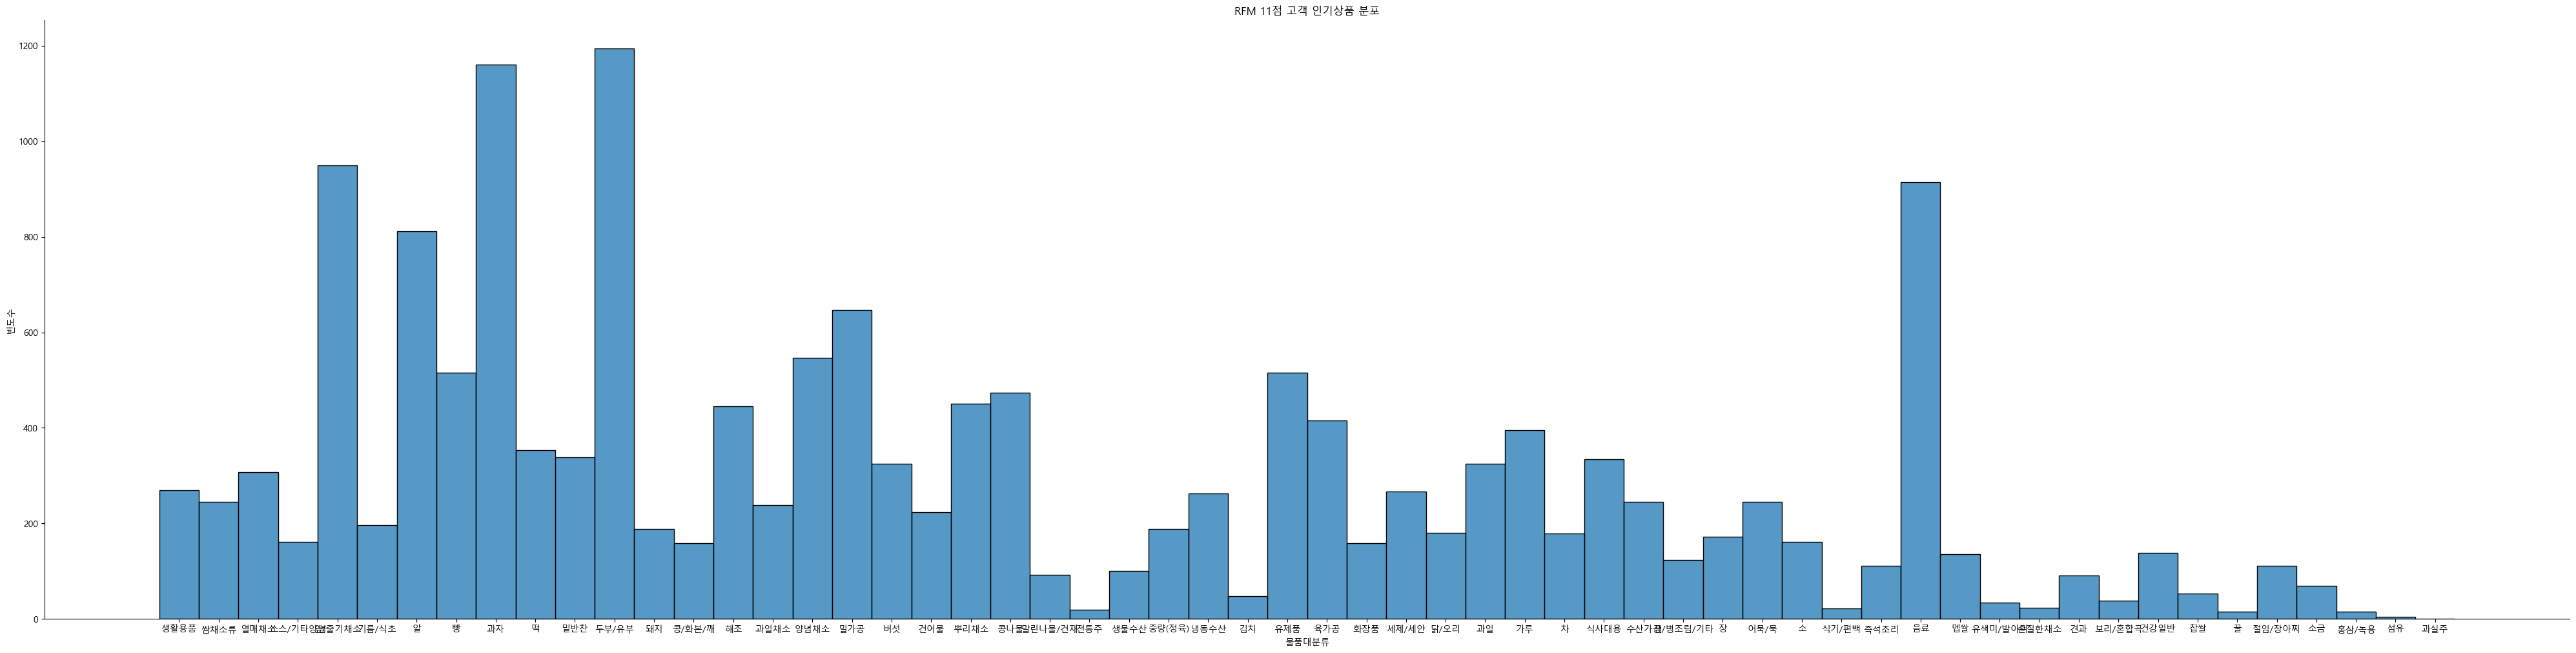

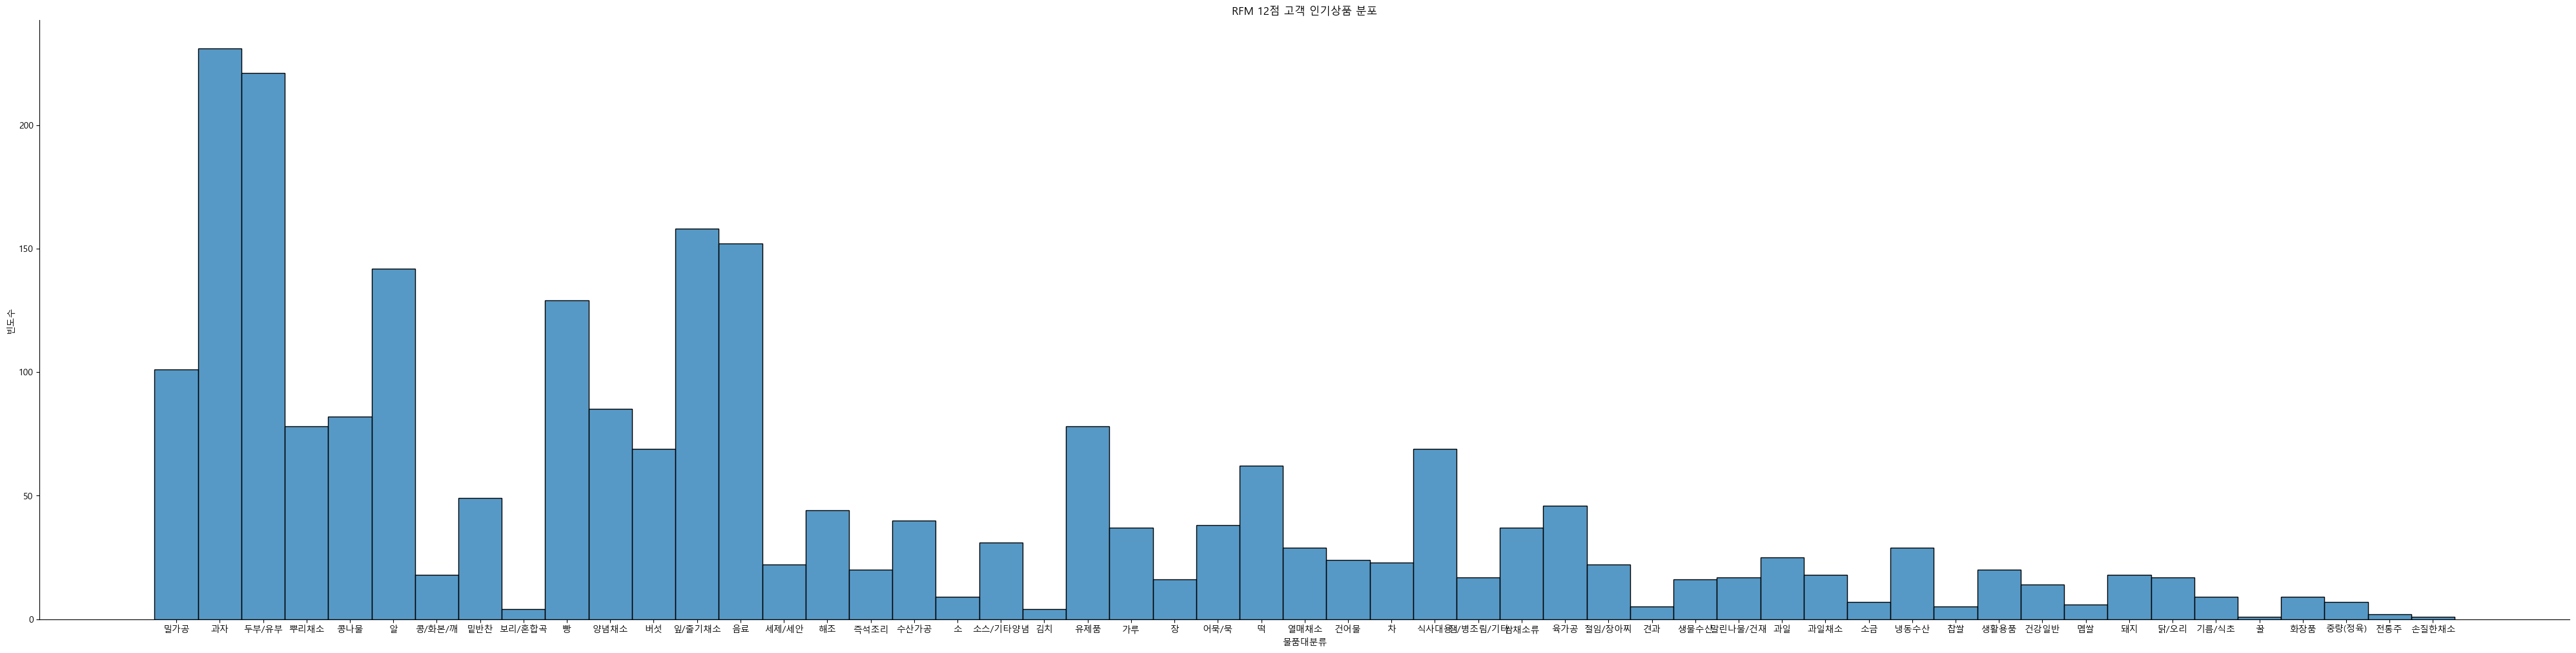

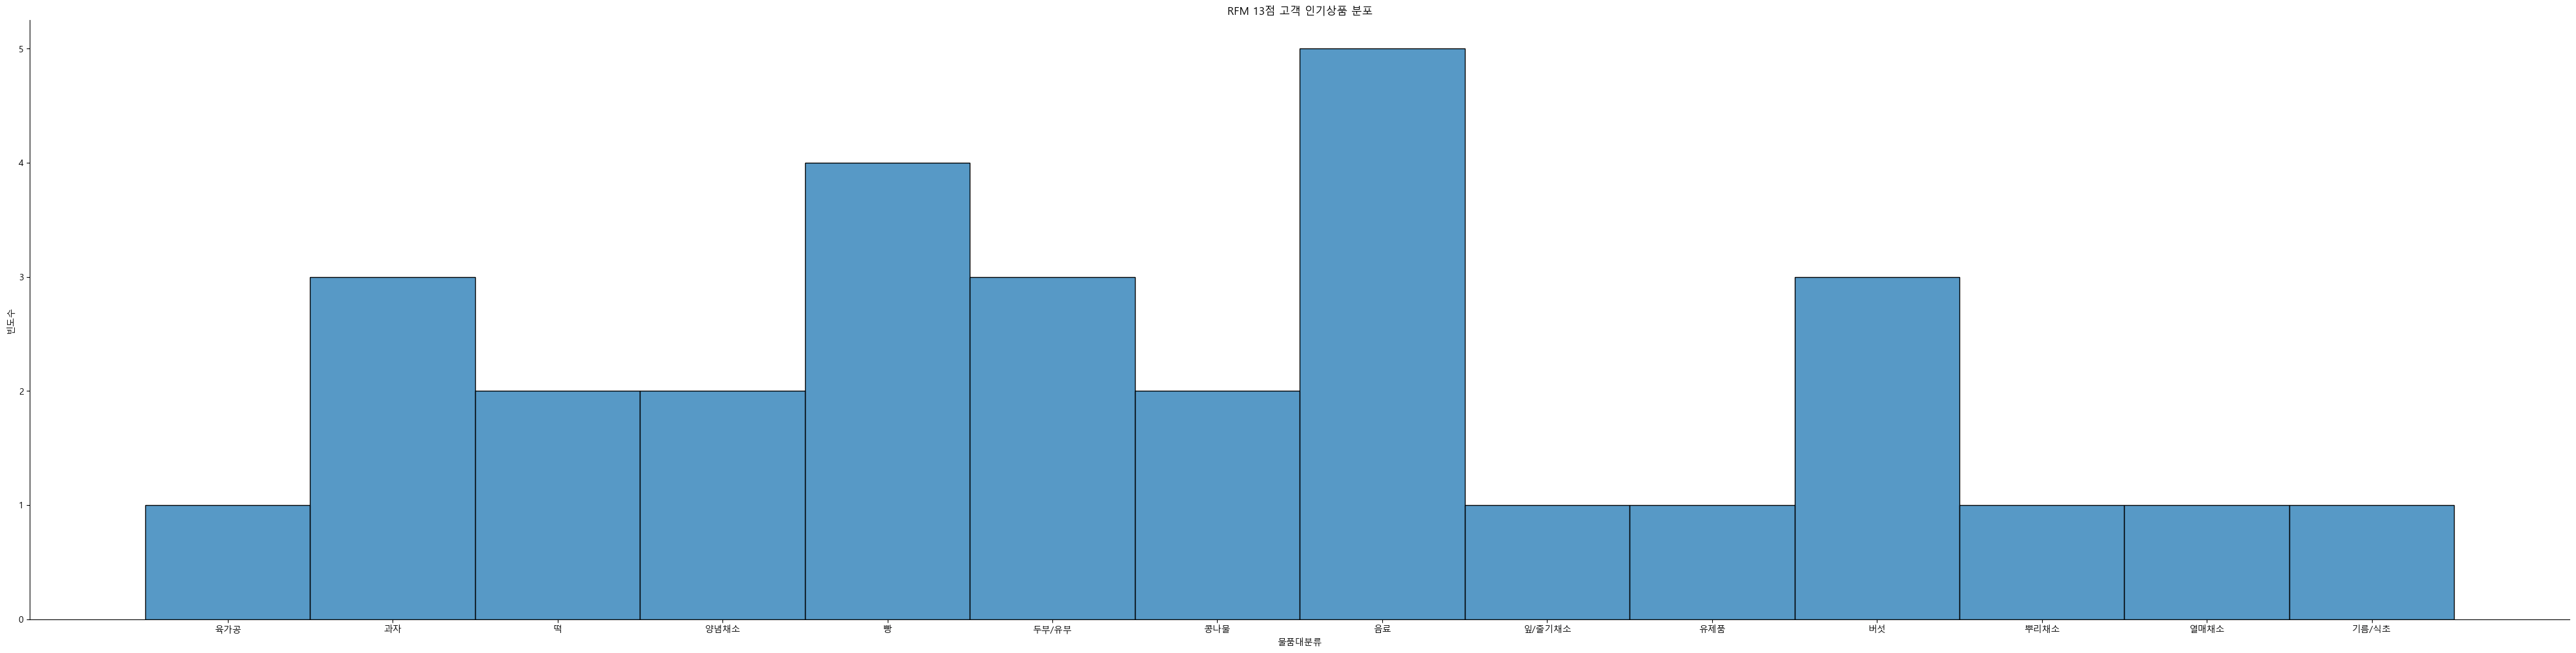

In [33]:
RFM_Score_list = [5, 6, 7, 8, 9, 10, 11, 12, 13]

for score in RFM_Score_list :
    RFM_cond = df_merged_RFM['RFM_Score'] == score
    df_RFM_Score = df_merged_RFM.loc[RFM_cond]

    # RFM_Score 점수 별 인기상품 시각화 (X - 물품대분류 / Y - 판매개수)
    sns.displot(data = df_RFM_Score, x = '물품대분류', height=10, aspect=4)
    plt.xlabel('물품대분류')
    plt.ylabel('빈도수')
    plt.title(f'RFM {score}점 고객 인기상품 분포')

    # 그래프 이미지파일로 저장
    plt.savefig(f'RFM_{score}score_popular_products_image.png')

# 고객 RFM점수 별 물품 판매 개수 출력

In [36]:
# 각 고객 RFM점수에 해당하는 물품대분류 별 상품 판매 수
for score in RFM_Score_list :
    RFM_cond = df_merged_RFM['RFM_Score'] == score
    df_RFM_Score = df_merged_RFM.loc[RFM_cond]

    print(f"<< RFM {score}점 물품대분류 별 상품 판매 갯수 >>")
    print(df_RFM_Score['물품대분류'].value_counts())
    print("\n\n")

<< RFM 5점 물품대분류 별 상품 판매 갯수 >>
물품대분류
건강일반      10
중량(정육)     5
육가공        3
보리/혼합곡     2
소금         1
수산가공       1
냉동수산       1
열매채소       1
두부/유부      1
닭/오리       1
어묵/묵       1
가루         1
과일         1
해조         1
Name: count, dtype: int64



<< RFM 6점 물품대분류 별 상품 판매 갯수 >>
물품대분류
두부/유부       368
알           328
음료          278
과자          223
밀가공         217
잎/줄기채소      210
육가공         200
중량(정육)      182
유제품         172
열매채소        170
소           166
냉동수산        155
과일          152
양념채소        152
빵           150
떡           139
밑반찬         139
건강일반        138
가루          138
건어물         136
뿌리채소        132
해조          130
화장품         125
수산가공        122
돼지          115
멥쌀          114
콩나물         114
닭/오리        113
식사대용        112
생활용품         96
기름/식초        90
과일채소         89
장            81
소스/기타양념      80
세제/세안        76
버섯           70
콩/화본/깨       69
어묵/묵         69
쌈채소류         63
잼/병조림/기타     61
차            55
즉석조리         47
절임/장아찌       45
말린나물/건재      42
견과           

In [38]:
# RFM점수에 해당하는 물품중분류 별 상품 판매 수
for score in RFM_Score_list :
    RFM_cond = df_merged_RFM['RFM_Score'] == score
    df_RFM_Score = df_merged_RFM.loc[RFM_cond]

    print(f"<< RFM {score}점 물품중분류 별 상품 판매 갯수 >>")
    print(df_RFM_Score['물품중분류'].value_counts())
    print("\n\n")

<< RFM 5점 물품중분류 별 상품 판매 갯수 >>
물품중분류
추출/농축액    10
돼지(중량)     5
식육추출가공     3
보리         2
가공소금       1
젓갈/액젓      1
기타냉동수산     1
찰옥수수       1
콩가공/기타     1
무항생제닭      1
묵          1
고춧가루       1
귤(조생)      1
미역/다시마     1
Name: count, dtype: int64



<< RFM 6점 물품중분류 별 상품 판매 갯수 >>
물품중분류
두부         330
논지엠오유정란    252
스낵         157
추출/농축액     130
멥쌀         114
          ... 
베타쌈배추        1
레몬           1
비타민고추        1
씀바귀          1
돌나물          1
Name: count, Length: 295, dtype: int64



<< RFM 7점 물품중분류 별 상품 판매 갯수 >>
물품중분류
두부         21415
논지엠오유정란    16431
스낵         12926
우유/산양유      8805
콩나물         7415
           ...  
개복숭아           2
청갓             1
오가피순           1
가루/기타          1
즙용브로컬리         1
Name: count, Length: 380, dtype: int64



<< RFM 8점 물품중분류 별 상품 판매 갯수 >>
물품중분류
두부         11318
논지엠오유정란     7357
스낵          5564
콩나물         3655
우유/산양유      3479
           ...  
울금             1
아동             1
영지버섯           1
마              1
떡케이크/선물        1
Name: count, Length: 3